# To Do:
- make sure adding edges works

### references:


In [4]:
#printing: sys.stdout.write(f'\r  ...progress: {curRow * tilesY} / {tilesX * tilesY} ({pct:.2f}%)')

### Imports:

In [ ]:
from lxml import etree
from lxml.etree import XMLSyntaxError
import pandas as pd
import sys
import os
import networkx as nx
from natsort import index_natsorted, order_by_index

In [9]:
source = "dblp.xml" #dataset of publications
dtd = etree.DTD(file="dblp.dtd") #read DTD
publication_data = [] #fill this list with pairs of author/title
counter = 0
bad_titles = ["Home Page", "Title Page", "Welcome message.", "Workshop preface.", "Vorwort.", "The", "The ", "Session Summary.", "Reviewers.", "Program Committee.", 
    "Preface.", "Organizing Committee.", "Workshop Organization.", "Workshop Organizers' Message.", "Title Page.", "Steering Committee.", "Session details: Keynote Address.",
    "S"]
#iterate through nodes
for event, element in etree.iterparse(source, load_dtd=True):
    title = ""
    author_list = []
    year = 0
    #iterate through children: author, title, year, etc.
    for child in element:
        if child.tag == "author":
            counter+=1
        elif child.tag == "title":
            title = str(child.text)
            if title in bad_titles:
                title = "";
            # break
    if counter % 10000 == 0:
        sys.stdout.write(f'\r  progress:  {counter}  rows')
    if counter >= 1000000:
        print("\nbroke")
        break
#create dataframe
publication_df = pd.DataFrame(publication_data)

element.clear()

  progress:  1000000  rows
broke


## Working approach:

In [11]:
source = "dblp.xml" #dataset of publications
dtd = etree.DTD(file="dblp.dtd") #read DTD
publication_data = [] #fill this list with pairs of author/title
edge_list = [] #fill this with edges
counter = 0
bad_titles = ["Home Page", "Title Page", "Welcome message.", "Workshop preface.", "Vorwort.", "The", "The ", "Session Summary.", "Reviewers.", "Program Committee.", 
    "Preface.", "Organizing Committee.", "Workshop Organization.", "Workshop Organizers' Message.", "Title Page.", "Steering Committee.", "Session details: Keynote Address.",
    "S"]
#iterate through nodes
for event, element in etree.iterparse(source, load_dtd=True):
    title = ""
    author_list = []
    year = 0
    #iterate through children: author, title, year, etc.
    for child in element:
        if child.tag == "author":
            author_list.append(str(child.text))
        elif child.tag == "title":
            title = str(child.text)
            if title in bad_titles:
                title = ""; 
        elif child.tag == "year":
            year = int(child.text)
            for author in author_list:
                publication_data.append({"Author" : author.strip(), "Title" : title.strip(), "Year" : year}) #add author/title/year pair to data list
            if len(author_list) > 1:
                edge_list.append(author_list)
            counter += 1
            break
    if counter % 10000 == 0:
        sys.stdout.write(f'\r  progress:  {counter}  rows')
    if counter > 1000000:
        print("\nbroke")
        break
#create dataframe
publication_df = pd.DataFrame(publication_data)
edges_df = pd.DataFrame(edge_list)
element.clear()

  progress:  1000000  rowsbroke


In [ ]:
publication_df.sample(10)

### Converting Dataframe to CSV

In [13]:
publication_df.to_csv('data.csv')
edges_df.to_csv('edges.csv')
print(len(publication_df))
print(len(edges_df))

2951926
777398


### Converting CSV to graph: adding authors as nodes

In [58]:
publication_df = pd.read_csv("data.csv")
publication_df = publication_df.reindex(index=order_by_index(publication_df.index, index_natsorted(publication_df['Author'], reverse=False))) # sorting by author name
publication_df.to_csv('data.csv')


In [86]:
# for row in len(publication_df):
author_graph = nx.Graph()
publication_df = pd.read_csv("data.csv")
author_graph.add_node(publication_df["Author"][0], Publications = {publication_df["Title"][0]})
for row in range (1,1000):
    author = publication_df["Author"][row]
    if author == publication_df["Author"][row-1]:
        author_graph.nodes[author]["Publications"].add(publication_df["Title"][row]) #adding title to list of publications from that author
    else:
        author_graph.add_node(author, Publications = {publication_df["Title"][row]}) #adding author to graph with title to attibute
print("Number of unique authors: " + str(len(author_graph.nodes)))

Number of unique authors: 948


In [ ]:
author_graph.nodes.data()

### Sorting CSV by title and url

In [ ]:
import pandas as pd
from natsort import index_natsorted, order_by_index
publication_df1 = pd.read_csv("data.csv")
# publication_df1 = publication_df1.reindex(index=order_by_index(publication_df1.index, index_natsorted(publication_df1['Url'], reverse=False)))
publication_df1 = publication_df1.reindex(index=order_by_index(publication_df1.index, index_natsorted(publication_df1['Title'], reverse=True)))
publication_df1.to_csv('data.csv')

C:\Users\mail4\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Adding edges for authors that share title

In [ ]:
from itertools import combinations
row = 0
while (publication_df2["Title"][row] != "None"): #for all elements with a title
# while row < len(publication_df2)-5:
    next = 1
    current_author = publication_df2["Author"][row]
    co_authors = [current_author] #list of coauthors
    while publication_df2["Title"][row] ==  publication_df2["Title"][row + next]: #find all authors with same title
        if (current_author !=  publication_df2["Author"][row + next]) and (publication_df2["Year"][row] ==  publication_df2["Year"][row + next]): #make sure no edges between same author
            co_authors.append(publication_df2["Author"][row + next]) #add to list of co-authors
            print(publication_df2["Title"][row])
        next += 1
    author_graph.add_edges_from(list(combinations(co_authors, 2))) #add edges between all coauthors
    row += 1
print("Last row with a title: " + str(row))
print("Number of edges: " + str(len(author_graph.edges)))

### Adding edges for authors that share URL

In [19]:
row = 352356
while row < len(publication_df2) - 1: #for all elements with no title
    next = 1
    co_authors = [publication_df2["Author"][row]] #list of coauthors
    while publication_df2["Url"][row] ==  publication_df2["Url"][row + next]: #find all authors with same title
        if (publication_df2["Author"][row] !=  publication_df2["Author"][row + next]) and (publication_df2["Year"][row] ==  publication_df2["Year"][row + next]): #make sure no edges between same author
            co_authors.append(publication_df2["Author"][row + next]) #add to list of co-authors
        next += 1
    author_graph.add_edges_from(list(combinations(co_authors, 2))) #add edges between all coauthors
    row += 1
print("Number of edges: " + str(len(author_graph.edges)))

Number of edges: 566


### Observations

In [20]:
print(str(sorted(author_graph.degree, key=lambda x: x[1], reverse=True)[0:10]) + "\n") # 10 authors with most coauthors

# google pagerank algorithm (error with this)
pageranks = nx.pagerank(author_graph) # A dictionary
print(sorted(pageranks, key=lambda x: x[1], reverse=True)[0:10]) # 10 authors with highest pageranks score (sharing publications with more important authors)

[('Manfred Broy', 17), ('Reinhard Wilhelm', 17), ('Arndt Bode', 17), ('Theo Härder', 17), ('Kurt Mehlhorn', 17), ('C. A. Petri 0001', 17), ('Günter Hotz', 17), ('Ingo Wegener', 17), ('Thomas Lengauer', 17), ('Volker Strassen', 17)]

['Jürgen Pfeffer', 'Jürgen Kosel', 'Cüneyt Bayilmis', 'Müge Akbulut', 'Jürgen Becker 0001', 'Hülya Malatyali', 'Rüdiger Valk', 'Jürgen Gornas', 'Hüseyin Arslan', 'Bülent Durak']


### Save graph as a graphml

In [20]:
import networkx as nx
nx.write_graphml(author_graph, "author_graph.graphml")

### Read graphml back into networkX graph

In [21]:
import networkx as nx
author_graph = nx.read_graphml("author_graph.graphml")

In [2]:
import pandas as pd
df = pd.read_csv("data.csv")
count = 0
for i in range(len(df)):
    if df["Author"][i] == "Thomas Seidl 0001":
        count += 1
print(count)

C:\Users\mail4\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


99


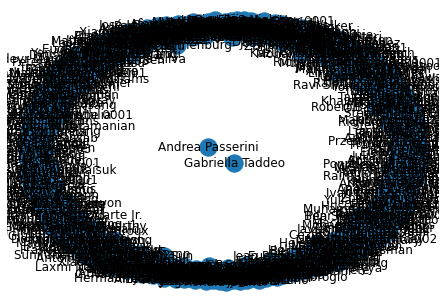

In [27]:
import networkx as nx
import pandas as pd
df = pd.read_csv("data.csv")
author_graph = nx.read_graphml("author_graph.graphml")
authors = df["Author"]
author_list = authors.sample(500)
subgraph = author_graph.subgraph(author_list)
nx.draw(subgraph, with_labels = True)